In [1]:
from __future__ import print_function
from pylab import *
import math
import numpy as np
import matplotlib.pyplot as plt


#Set global variables.
epsilon = 0.0001 #tolerance to calculate collision time
#gamma = 0.2
#gamma = 1/math.sqrt(2)

#Create two arrays with x and y coordinates of vertices of the table here.
#Always have the coordinates ordered in clockwise direction
def create_table(x,y):
    
    #table_shape = figure(1)
    #Throw exceptions if there aren't enough vertices or if the arrays with x and y coordiantes don't have same length.
    if len(x) < 3:
        raise Exception('Error: You need at least three sets of points of build the table.')
    elif len(x) != len(y):
        raise Exception('Error: The array with x and y coordinates are of different length.')
        
    #Find the number of vertices.     
    nw = len(x)
    
    #Set curve type for each wall MANUALLY;  1 for line, 0 for circle.
    curve_type = [1]*nw
    
    #Set collision type for each wall MANUALLY;  0 for specular/smooth, 1 for rough/spin.
    collision_type = [0]*nw 
    
    #Initialize the table.
    table =  []
    
    #Build the walls.
    for i in range(nw):
        x0,y0 = x[i], y[i]
        
        #When at the final vertex, next coordinate needs to be the initial vertex.
        if i ==  nw-1:
            i = -1
            
        #Find the parameters for each wall.    
        x1,y1 = x[i+1], y[i+1]
        mag = ((x1-x0)**2 + (y1-y0)**2)**0.5
        xdot0, ydot0 = (x1-x0)/mag,(y1-y0)/mag
        
        #Plot the particular wall.
        plt.plot([x0,x1], [y0,y1], 'k-', lw=2)
        
        
        #Append the walls to the table one by one.
        table = np.append(table, [x0,y0,x1,y1,xdot0, ydot0, curve_type[i], collision_type[i]])
        
    #Reshape the table to correct dimensions.   
    table = np.reshape(table, (nw,8))
    
    return np.asarray(table)    

#Calculate the slope for a given pair of points.
def slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1) 

#Calculate the distance between any two points
def distance(x1,y1,x2,y2):
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

#Determine if a point lies between two points
def is_between(ax,ay,bx,by,cx,cy):
    return -epsilon < (distance(ax,ay,cx,cy) + distance(cx,cy,bx,by) - distance(ax,ay,bx,by)) < epsilon

#Find the parametrized length at the collision point
def parametrized_length(x_col,y_col,wall_index,nw):
    table_length = 0
    col_length = 0
    for i in range(nw):
        x1 = table[i][0]
        y1 = table[i][1]
        x2 = table[i][2]
        y2 = table[i][3]
        
        #Find the table length by adding each wall
        table_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
        
        #Find wall length up to the collision point
        if i < wall_index:
            col_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
        #Add the right fraction of the final wall
        if i == wall_index:
            col_length += ((x_col-x1)**2 + (y_col-y1)**2)**0.5
    
    #Parametrize s as a fraction of total table length.
    s = col_length/table_length
    
    return s



In [2]:
#Set global variables.
#epsilon = 0.0001 #tolerance to calculate collision time

def create_ngon(nw,length):
    table = []
    xstart,ystart = [length,0]
    ux,uy = [-1,0]
    xend,yend = length*np.array([0,0])
    c = 1
    m = 0 
    table =  np.array([xstart, ystart, xend, yend, ux, uy, c, m])
    theta = 2*math.pi/nw
    plt.plot([xstart,xend], [ystart,yend], 'k-', lw=2)
    for i in range(1,nw):
        
        #Plot the particular wall.       
        xstart = xend
        ystart = yend
        uxinit = ux
        uyinit = uy
        uxfinal = cos(theta)*uxinit + sin(theta)*uyinit
        uyfinal = -sin(theta)*uxinit + cos(theta)*uyinit
        xend = xstart + length*uxfinal
        yend = ystart + length*uyfinal
        ux = uxfinal
        uy = uyfinal
        
        plt.plot([xstart,xend], [ystart,yend], 'k-', lw=2)
        table = np.append(table,[xstart, ystart, xend, yend, ux, uy, c, m], axis=0)

    table = np.reshape(table,(nw,8))
    return table

def reflection_vector(x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma):
       
        wall_index = int(wall_index)
        vector_in = [omega0,xdot0,ydot0]
        
        #Find wall vector
        wall_x = table[wall_index][4]
        wall_y = table[wall_index][5]
        wall_dir = [wall_x, wall_y]
        
        #Create 90 deg clockwise rotation matrix to get normal
        rot_mat_clockwise_ninety = np.array([[cos(math.pi/2), sin(math.pi/2)],
                                 [-sin(math.pi/2), cos(math.pi/2)]])
        
        #Find the normal by rotating the wall clockwise 90 degrees
        normal = np.matmul(rot_mat_clockwise_ninety,wall_dir)
        
        #change normal to a 3D vector
        normal = np.append(normal, [0])
        #print(normal)
        
        #Find the angle between normal and y-axis
        theta = math.acos(np.dot(normal,[0,1,0]))
      
        
        #Find out how much anti-clockwise rotation is needed to align the normal with y-axis
        temp_num =  np.cross(normal, [0,1,0])[2]
        if temp_num < 0:                   
            theta = 2*math.pi-theta
        #print(theta)
        
        #Create anti-clockwise rotation matrix
        rot_mat = np.array([[-1,0,0],
                        [0,cos(theta), -sin(theta)],
                      [0,sin(theta), cos(theta)]])
        #print(rot_mat)
        
        #Create the reflection matrix 
        #gamma is the mass distribution, 0 for specular, non-zero for non-specular
        reflect_mat = np.array([[-(1-gamma**2)/(1+gamma**2), -2*gamma/(1+gamma**2),0],
                                [-2*gamma/(1+gamma**2),(1-gamma**2)/(1+gamma**2),0],
                               [0,0,-1]])
        #print(reflect_mat)

        #Find the reflection vector through matrix transformation
        vector_out = np.matmul(rot_mat,vector_in)
        vector_out_tangent = np.matmul(reflect_mat,vector_out)
        vector_out = np.matmul(np.transpose(rot_mat),vector_out_tangent)
        #vector_out = -1*vector_out
        #print(vector_out[1:])
        #print(normal[:2])
        
        #Find phase angle, phi
        phi = math.acos(np.dot(vector_out[1:],normal[:2]))
    
        #print(phi)
     
        #Return reflection vector along with phase angle.
        
        temp = np.append(vector_out,vector_out_tangent)
        return np.append(temp,phi)
    
def collision(x0,y0,omega0,xdot0,ydot0,nw,gamma):
    #Initialize collision output matrix.
    col_mat = []
    
    #Compute collision times for all walls.
    for i in range(nw):
        x1 = table[i][0]
        y1 = table[i][1]
        x2 = table[i][2]
        y2 = table[i][3]
        vx_wall = table[i][4]
        vy_wall = table[i][5]
        #Check for walls with undefined slope.
        #Tf there is one, find the collision point and wall index.
        if x1 == x2: 
            t = (x1-x0)/xdot0
            x = x1
            y = y0 + ydot0*t
            col_mat = np.append(col_mat,[x,y,t,i])
        #Check for walls that are parallel.    
        elif abs(np.cross([vx_wall,vy_wall], [xdot0,ydot0])) < epsilon:
            col_mat = np.append(col_mat,[100,100,-1,i])
        #Compute collision times for the remaining walls with defined slopes.  
        else:    
            m = slope(x1,y1,x2,y2)
            b = np.array([x0,y0,y1-m*x1])
            A = np.array([[1,0,-xdot0],
                [0,1,-ydot0],
                [-m,1,0]])
            A_inverse = np.linalg.inv(A) 
            col_mat = np.append(col_mat,np.append(np.matmul(A_inverse,b),[i])) 
    
    #Reshape the collision matrix for all alls
    col_mat = np.reshape(col_mat, (nw,4))
    #print("collision matrix")
    #print(col_mat)
    
    #Find the wall that the particle hits at minimum positive time.
    
    #min_time = min([n for n in col_mat[:,2]  if n > epsilon]) 
    #wall_index, min_index_column = np.where(col_mat == time)
    #col_output = np.array(col_mat[col_index_row,:])
    
    #General approach that works for any polygon
    #min_time = min([n for n in col_mat[:,2]  if n > epsilon])
    temp = []
    counter = 0
    for i in range(nw):
        ax = table[i][0]
        ay = table[i][1]
        bx = table[i][2]
        by = table[i][3]
        cx = col_mat[i][0]
        cy = col_mat[i][1]
        col_time = col_mat[i][2]

        if is_between(ax,ay,bx,by,cx,cy):
            temp = np.append(temp,col_mat[i,:],axis = 0)
            counter += 1
    #temp is the matrix with collision points that lie on the walls         
    temp = np.reshape(temp,(counter,4))
    #print(temp)
    
    #Find the minimum time out of the sorted walls
    min_time = min([n for n in temp[:,2]  if n > epsilon]) 
    
    #Find the row number for the minimum 
    row_number, column = np.where(temp == min_time)
    
    #Extract wall with minimum collision time and collision location.        
    col_output = temp[row_number,:]

    #Extract collision parameters
    x_col, y_col, t_col, wall_index = col_output[0,:]

    #Find the reflection vector and the phase angle phi, returns, vx_out,_vy_out, phi
    #print([x_col,y_col,xdot0,ydot0])
    vector_out = reflection_vector(x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma)
    #print("vector_out")
    #print(vector_out)
    
    #Find the parameterized length of collision point and add it to the output
    s = parametrized_length(x_col,y_col,wall_index,nw) 
    
    #Append parametrized length, vector out, and phase angle to collision output
    col_output = np.append(col_output,s)
    col_output = np.append(col_output,vector_out)    
    
    return np.asarray(col_output)


#this functions runs the simulation and outputs a matrix vector 
def polygon_sim(x0,y0,omega0,xdot0,ydot0,count,gamma):
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])
    
    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        #plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0
    
    #Find the parameters after collision
    while n < count:
        c = collision(x0,y0,omega0,xdot0,ydot0,nw,gamma)
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        #plt.plot([x0,xtemp], [y0,ytemp], 'k-', lw=0.25) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (n,7))
    
    #Set figure size
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(6, 6)
    
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    return np.array(output)

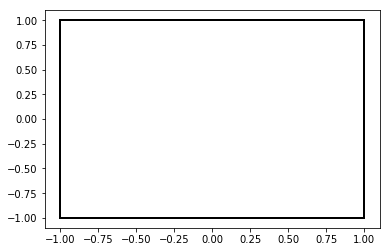

In [3]:
#Create a table with given vertices.
#IMPORTANT: Always have the coordinates ordered in clockwise direction.
#table = create_ngon(6,2)
#table = create_table([-50,-50,50,50],[-1,1,1,-1])
table = create_table([-1,-1,1,1],[-1,1,1,-1])


In [4]:
#output = polygon_sim(0,0.5,1,math.sqrt(5)*table[3][4],table[3][5],100,0.1)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(6, 6)

#np.set_printoptions(threshold=np.inf)
#print(output)

<IPython.core.display.Javascript object>


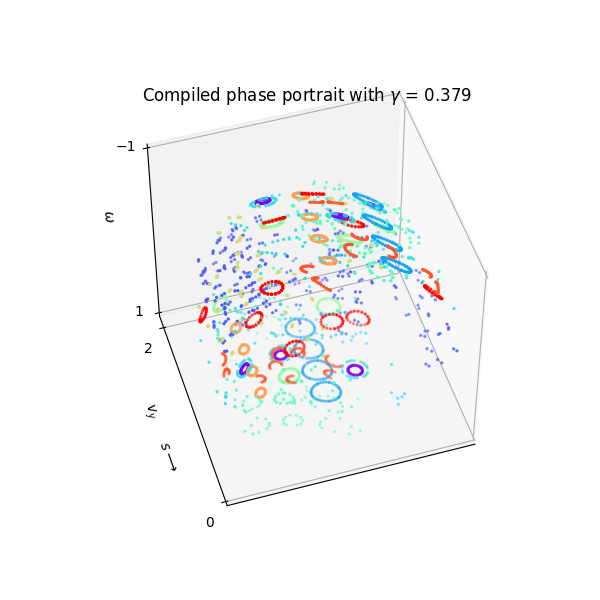

<IPython.core.display.Javascript object>


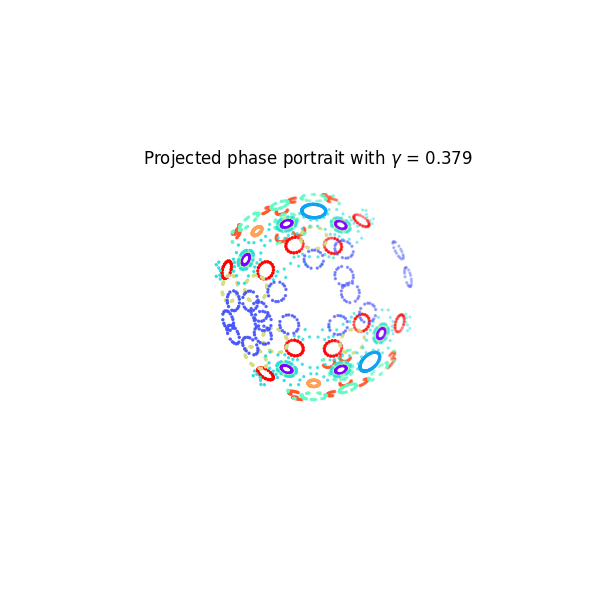

In [4]:
%matplotlib notebook
from mpl_toolkits import mplot3d

#Set simulation parameters
collision_count = 300 #collision count for each loop
sim_count = 10 #no. of simlulations
#gamma= np.random.random_sample()
gamma = 0.37925 #mass distribution constant
#generate colors for each run
cmap= cm.rainbow(np.linspace(0,1,sim_count))

#Set properties for 3D phase space
phase_portrait_3D = figure(2)
axes = plt.axes(projection='3d')
axes.set_title('Compiled phase portrait with $\gamma$ = %1.3f'%gamma, y=1)
#axes.set_title('Compiled phase portrait with $\gamma$ = %1.3f'%gamma, y = 1.10)
axes.set_ylabel('$v_y \:\:\:\:\:\:\:\:\: s\longrightarrow$')
axes.set_zlabel('$\omega$')
phase_portrait_3D.set_size_inches(6, 6)
axes.set_xlim([-1,1])
axes.set_ylim([0,2.1])
axes.set_zlim([-1,1])
axes.set_xticks([])
axes.set_yticks([0,2])
axes.set_zticks([-1,1])
axes.view_init(elev=0, azim=0)

#Set properties for projected phase space
phase_portrait_projected = figure(3)
axes2 = plt.axes(projection='3d') 
phase_portrait_projected.set_size_inches(6, 6)
axes2.set_title('Projected phase portrait with $\gamma$ = %1.3f'%gamma, y = 0.85)
#axes2.set_title('Projected phase portrait with $\gamma$ = %1.3f'%gamma, y = 1.10)
axes2.view_init(elev=0, azim=90)
axes2.set_xlim([-1.2,1.2])
axes2.set_zlim([-1.2,1.2])
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_zticks([])
plt.axis('off')

#Run the simulation and plot results 
output = []
#color_index =[]

#temp = np.random.uniform(math.pi/2 - 0.5, math.pi/2 + 0.5, sim_count)
for i in range (sim_count):
    omega0 = np.random.uniform(-1,1)
    xdot0 = np.random.uniform(-1,1)
    ydot0 = np.random.uniform(-1,1)
    #theta_random = 2*math.pi*np.random.random_sample()
    try:
        output_temp = polygon_sim(0,0.2,omega0,xdot0,ydot0,collision_count,gamma)
        output = np.append(output,output_temp)
        #color_index = np.append(color_index, i)
    except Exception as e:
        print(e)
        print("Hit a corner most likely..")
        continue
    color_temp = cmap[i,:]
    phase_portrait_3D,axes.scatter(output_temp[:,3],output_temp[:,4]+output_temp[:,5],output_temp[:,2], color = color_temp,s = 2)
    phase_portrait_projected,axes2.scatter(output_temp[:,3],0,output_temp[:,2], color = color_temp,s = 2)

output = np.reshape(output, (-1,7))    
    

<IPython.core.display.Javascript object>


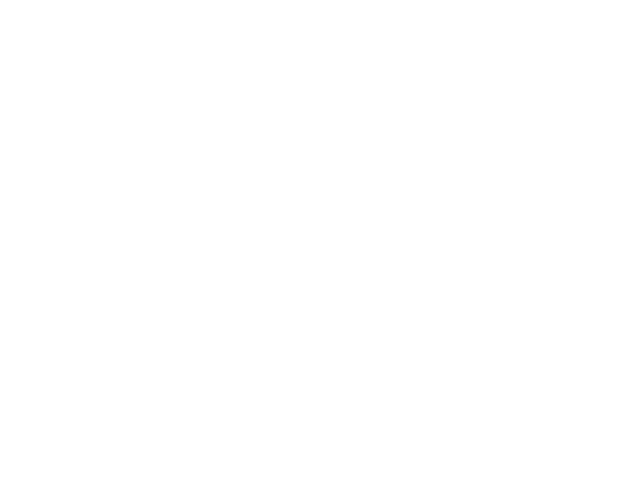

interactive(children=(FloatSlider(value=-0.4, continuous_update=False, description='omega0', max=1.0, min=-1.0…

<function __main__.polygon_sim_interact(x0, y0, omega0, xdot0, ydot0, count, gamma)>

In [10]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#table = create_table([-50,-50,50,50],[-1,1,1,-1])
table = create_table([-1,-1,1,1],[-1,1,1,-1])
plt.close()
#table = create_ngon(5,1)
gamma = 1
 
def polygon_sim_interact(x0,y0,omega0,xdot0,ydot0,count,gamma):
    #billiard table figure
    billiard_table = figure(4)
    plt.clf()
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])
    
    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        billiard_table,plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0
    
    #Find the parameters after collision
    while n < count:
        c = collision(x0,y0,omega0,xdot0,ydot0,nw,gamma)  
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        plt.plot([x0,xtemp], [y0,ytemp], 'b-', lw=0.75) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (-1,7))
    
     
    plt.title('Square with $\gamma$ = %1.1f' %gamma, y= 0.95)
    billiard_table.set_size_inches(3, 3)
    #plt.xlim([-2.1,2.1])
    plt.show()
    #plt.autoscale(enable=True, axis='both', tight=None)
    plt.axis('equal')
    plt.axis('off')
    
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    #return np.array(output)

#polygon_sim(x0,y0,omega0,xdot0,ydot0,count
interact(polygon_sim_interact, x0 = fixed(0.0),\
                                y0 = fixed(0.2),\
                                omega0 = widgets.FloatSlider(min=-1,max=1,step=0.01,value=-0.4, continuous_update=False),\
                                xdot0 = widgets.FloatSlider(min=-1,max=1,step=0.01,value=0.29, continuous_update=False),\
                                ydot0 = widgets.FloatSlider(min=-1,max=1,step=0.01,value=-0.29, continuous_update=False),\
                                count = widgets.IntSlider(min=0,max=2000,step=1,value=100,continuous_update=False),
                                gamma = widgets.FloatSlider(min=0,max=1,step=0.0001,value=gamma,continuous_update=False))





<IPython.core.display.Javascript object>


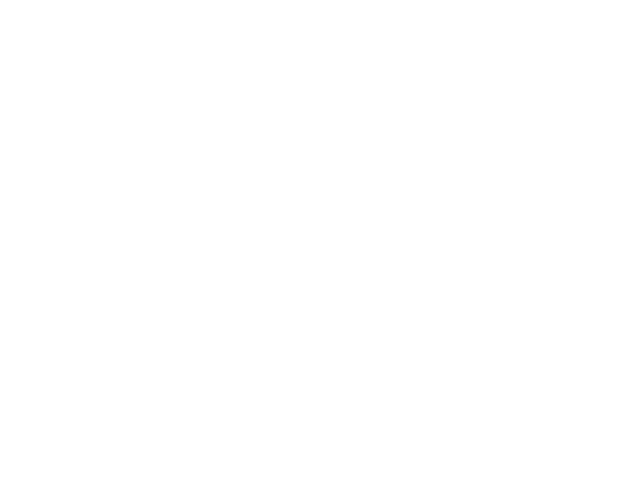

<IPython.core.display.Javascript object>


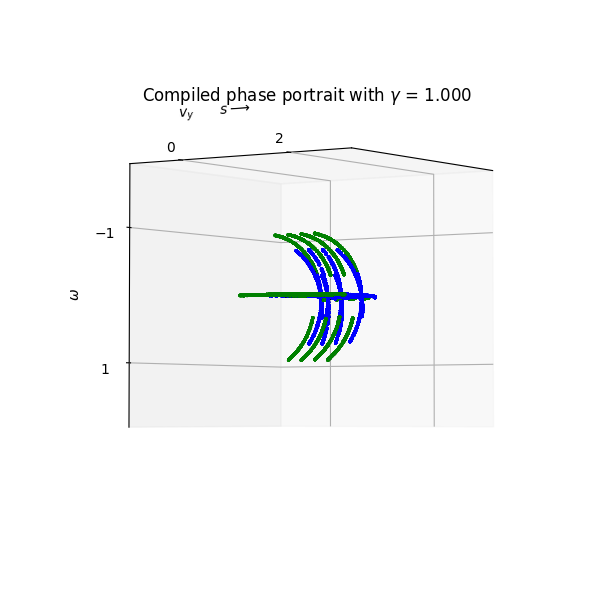

8
8
4
8
4
4
4
8
8
8
4
4
4
8
4
4
4
4
8
4
8
4
4
4
8
4
4
4
4
4
8
4
4
4
8
4
4
4
4
4
4
4
8
8
8
4
4
4
8
4
4
8
4
8
8
8
4
4
8
4
4
4
4
8
4
4
8
4
4
8
4
4
4
4
4
4
4
4
4
8
8
8
4
8
4
4
4
4
4
8
4
4
4
4
4
4
4
4
4
4
4
4
4
8
4
4
8
4
8
4
8
8
4
4
4
8
4
8
4
8
4
8
4
4
4
4
4
4
4
8
8
4
4
8
8
4
8
4
4
8
8
4
8
4
4
4
4
4
8
4
4
4
4
4
4
8
4
4
4
4
4
4
8
4
8
8
4
4
8
8
4
4
4
4
4
8
8
4
4
4
4
4
4
8
4
8
4
4
8
4
4
8
8
4
4
8
8
4
4
4
8
4
4
4
4
4
8
4
4
4
4
8
8
4
8
4
8
8
4
8
8
4
4
4
4
4
4
8
4
4
4
4
4
8
4
8
4
4
4
4
4
4
4
8
4
8
8
4
4
8
4
4
4
4
8
4
4
8
4
8
4
8
4
4
4
4
4
8
4
4
4
4
8
8
8
4
4
4
4
8
4
4
4
8
4
4
4
4
4
8
4
8
4
4
4
8
4
4
8
8
8
8
8
4
8
4
4
8
8
4
8
4
4
8
4
4
8
4
4
8
4
4
4
8
8
8
8
8
4
4
4
4
4
4
8
8
8
8
8
4
4
4
4
4
4
4
4
4
4
4
4
8
4
4
8
4
4
4
4
8
4
8
8
4
4
8
8
8
4
4
4
8
8
4
8
4
8
4
4
4
4
4
4
4
4
4
8
8
4
8
4
4
4
8
4
4
4
8
8
8
4
4
4
4
4
4
8
4
4
8
8
4
8
4
8
4
4
4
4
8
8
8
8
4
4
8
8
4
8
4
4
4
4
4
4
4
4
8
8
4
8
4
4
8
4
8
8
4
8
8
4
4
8
4
4
8
4
8
4
4
8
4
4
4
8
4
4
4
8
4
8
4
4
4
4
8
4
8
4
4
4
4
8
4
4
4
4
8
4
8
4
4
8
8
8
4
4
4
4
8


In [31]:
#sampling l shaped
import os
folderName = 'test'
epsilon = 1e-15


#table = create_table([0,1,1,0,-1,-1,-1,0],[0,0,1,1,1,0,-1,-1])
table = create_table([-1,-1,1,1],[-1,1,1,-1])

plt.close()
#table = create_ngon(5,1)
gamma = 1
         
count = 200    
#no. of sample N
N = 500

%matplotlib notebook
from mpl_toolkits import mplot3d
#generate colors for each run
cmap= cm.rainbow(np.linspace(0,1,N))

#Set properties for 3D phase space
phase_portrait_3D = figure(2)
axes = plt.axes(projection='3d')
axes.set_title('Compiled phase portrait with $\gamma$ = %1.3f'%gamma, y=1)
#axes.set_title('Compiled phase portrait with $\gamma$ = %1.3f'%gamma, y = 1.10)
axes.set_ylabel('$v_y \:\:\:\:\:\:\:\:\: s\longrightarrow$')
axes.set_zlabel('$\omega$')
phase_portrait_3D.set_size_inches(6, 6)
axes.set_xlim([-1,1])
axes.set_ylim([0,2.1])
axes.set_zlim([-1,1])
axes.set_xticks([])
axes.set_yticks([0,2])
axes.set_zticks([-1,1])
axes.view_init(elev=0, azim=0)

def polygon_sim_sampling(x0,y0,omega0,xdot0,ydot0,count,gamma,sample_number):
    #billiard table figure
    #billiard_table = figure(4)
    #plt.clf()
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])
    
    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        #billiard_table,plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0
    
    #Find the parameters after collision
    while n < count:
        c = collision(x0,y0,omega0,xdot0,ydot0,nw,gamma)  
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        #plt.plot([x0,xtemp], [y0,ytemp], 'b-', lw=0.75) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (-1,7))
    period = find_period(output)
    print(period)
    
    
     
    #plt.title('Billiard with $\gamma$ = %1.1f' %gamma, y= 0.95)
    
    #billiard_table.set_size_inches(6, 3)
    #plt.xlim([-2.1,2.1])
    #plt.show()
    #plt.autoscale(enable=True, axis='both', tight=None)
    
    #plt.axis('equal')
    #plt.axis('off')
    #plt.savefig(os.path.join(folderName, str(sample_number)) + '.eps', format='eps', dpi = 600)
    if period == 4:
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'b',s = 2)
    elif period == 6:
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'r',s = 2)
    elif period == 8:
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'g',s = 2)
    elif period == 10:
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'm',s = 2)
    elif period == 12:
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'c',s = 2)
    else: 
        phase_portrait_3D,axes.scatter(output[:,3],output[:,4]+output[:,5],output[:,2], color = 'k',s = 2)
    return period
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    #return np.array(output)

#at least 101 collisions required to find out if there is a period less than or equal to hundred    
def find_period(output):
    l = len(output[:,0])
    #print(l)
    period = -1

    for i in range(2,l):  
        difference =(output[i,5] - output[1,5])**2+(output[i,2] - output[1,2])**2+(output[i,6] - output[1,6])**2
        #print(difference)
            
        if difference < epsilon:
            period = i-1
            break         

    return period    
    

    
    
for i in range(N):
    x0 = -0.5
    y0 = 0.5
    theta_random = np.random.uniform(0, 2*pi)   
    #omega0 = np.random.uniform(-1,1)
    omega0 = 0
    xdot0 = math.cos(theta_random)
    ydot0 = math.sin(theta_random)  
    polygon_sim_sampling(x0,y0,omega0,xdot0,ydot0,200,gamma,i) 
    
    
    
    

In [33]:
plt.savefig('square_phase_by_period_no-initial-spin.eps', format='eps', dpi = 600)